In [1]:
# This notebook illustrates FUNMAN solving PDE models expressed as Petrinets 

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt
import itertools


RESOURCES = os.path.join(
   os.getcwd(), "../../Model-Representations/petrinet/examples/pde/"
)


def get_locations(dimensions, num_disc):
   locations = list(itertools.product(*[range(num_disc) for d in range(dimensions)]))
   locations = ["_".join([str(pos) for pos in location]) for location in locations]
   return locations

2024-01-11 04:25:54,210 - funman.server.worker - INFO - FunmanWorker running...
[1.00000, 1.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-01-11 04:25:54,220 - funman.server.worker - INFO - Starting work on: a28da5dd-478e-45d9-b23d-2ab6b1ddd354
2024-01-11 04:25:54,223 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!


2024-01-11 04:25:56,227 - funman.api.run - INFO - Dumping results to ./out/a28da5dd-478e-45d9-b23d-2ab6b1ddd354.json
2024-01-11 04:25:58,414 - funman.scenario.consistency - INFO - 5{5}:	[+]
2024-01-11 04:25:58,419 - funman.server.worker - INFO - Completed work on: a28da5dd-478e-45d9-b23d-2ab6b1ddd354
2024-01-11 04:26:06,281 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-01-11 04:26:06,427 - funman.server.worker - INFO - FunmanWorker exiting...
2024-01-11 04:26:06,430 - funman.server.worker - INFO - Worker.stop() completed.
2024-01-11 04:26:06,433 - /root/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2024-01-11 04:26:06,435 - /root/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2024-01-11 04:26:06,436 - /root/funman/auxiliary_packages/funman_demo/src

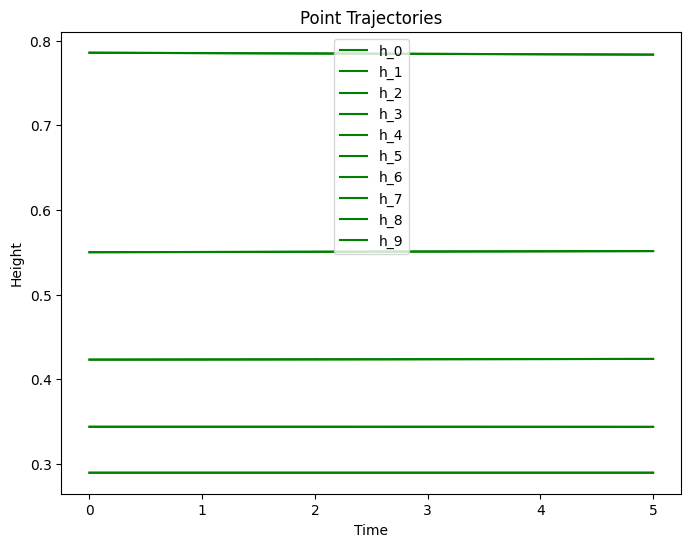

In [24]:
# Halfar Model

# Instance parameters (used to identify input file)
dimensions = 1
boundary_slope = 0.1
num_disc = 10
# derivative = "centered"
# derivative = "backward"
derivative = "forward"

EXAMPLE_DIR = os.path.join(RESOURCES, "halfar")
instance = f"halfar_{derivative}_{dimensions}_{boundary_slope}_{num_disc}.json"
instance_file = os.path.join(EXAMPLE_DIR, instance)

locations = get_locations(dimensions, num_disc)

# Funman parameters
steps = 5
dt = 1


# Create constraint pos_i on the height h at each location i
# pos_i: 0 <= h_i < 2, for i in [0, 4]

variables = [f"h_{loc}" for loc in locations]
height_bounds = [
    {
        "name": f"pos_{i}",
         "variable": i,
         "interval": {"lb": 0, "ub": 2}
    }
    for i in variables
]

# Create request for the analysis
# structure_parameters: timepoints to evaluate 
# parameters: A, dt
# constraints: height bounds (above), slope on boundaries is well-formed
# config: uses defaults

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {
                    "timepoints": range(0,(steps+1)*dt, dt)
                }
            ],
        },
        
    ],
    "parameters": [
        {
            "name": "A",
            "label":"any",
            "interval": {"lb":1e-20, "ub":1e-12}
         },
        # {
        #     "name": "dt",
        #     "label":"any",
        #     "interval": {"lb":1, "ub":11}
        #  },
         {
            "name": "dx",
            "label":"any",
            "interval": {"lb":1, "ub":1}
         }
    ],
    "constraints": height_bounds + 
    [
        # {"name": "LHS_slope",
        #     "variables": ["h_1", "h_0"],
        #     "weights": [1, -1],
        #     "additive_bounds": {"lb": 0},
        #     "timepoints": {"lb": 0}
        # }, 
        # {"name": "RHS_slope",
        #     "variables": ["h_3", "h_4"],
        #     "weights": [1, -1],
        #     "additive_bounds": {"lb": 0},
        #     "timepoints": {"lb": 0}
        # }
    #  {"name": "melt_h_5",
    #      "variable": "h_5",
    #      "interval": {"lb": 0, "ub": .8},
    #      "timepoints": {"lb": 5}
    #     },

        ],
    "config": {
    },
}


# Use request_dict
results = Runner().run(
    instance_file,
    request_dict,
    description=f"Halfar Demo {instance}",
    case_out_dir="./out",
    # dump_plot=True,
    parameters_to_plot=["A", "timestep"],
    point_plot_config = {
        "label_marker":{"true":",", "false": ","},  
    }
)

summarize_results(variables, results)
h, dh, anim_h, anim_dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

In [2]:
# Advection Model

# Instance parameters (used to identify input file)
dimensions = 2
boundary_slope = 0.0
num_disc = 5
# derivative = "centered"
derivative = "backward"
# derivative = "forward"

EXAMPLE_DIR = os.path.join(RESOURCES, "advection")
instance = f"advection_{derivative}_{dimensions}_{boundary_slope}_{num_disc}.json"
instance_file = os.path.join(EXAMPLE_DIR, instance)

locations = get_locations(dimensions, num_disc)

# Funman parameters
steps = 5
dt = 1


# The energy at each location is non-negative
variables = [f"a_{loc}" for loc in locations]
height_bounds = [
    {
        "name": f"pos_{i}",
         "variable": i,
         "interval": {"lb": 0}
    }
    for i in variables
]

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0,(steps+1)*dt, dt)}
            ],
        },
        
    ],
    "parameters":[
        {
            "name": "dx",
            "label":"any",
            #  "interval": {"lb":1e-18, "ub":1e-14}}
            "interval": {"lb":1, "ub":1}},
        {
            "name": "u",
            "label":"any",
            #  "interval": {"lb":1e-18, "ub":1e-14}}
            # "interval": {"lb":-1e-1, "ub":-1e-1} # Best for centered or forward derivatives
            "interval": {"lb":1e-1, "ub":1e-1} # Best for centered or backward derivatives
        }
    ],
    "constraints": 
    height_bounds + 
    [

        # 0 <= dx - u
        # u <= dx
        # {"name": "dx_gte_u",
        #     "variables": ["dx", "u"],
        #     "weights": [1, -1],
        #     "additive_bounds": {"lb": 0},
        #     # "timepoints": {"lb": 0}
        # }, 
 

        ],
    "config": {

    },
}



results = Runner().run(
    instance_file,
    request_dict,
    # REQUEST_PATH,
    description=f"Advection demo {instance}",
    case_out_dir="./out",
    point_plot_config={"variables":variables,},
    num_points=None
)

point_plot = summarize_results(variables, results)
display(point_plot)
plt.close()

h, dh, anim_h, anim_dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

[1.00000, 1.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])


[0.10000, 0.10000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-01-24 14:55:20,222 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!
2024-01-24 14:55:22,232 - funman.api.run - INFO - Dumping results to ./out/a93312e9-d687-4dab-8247-072cf7f7872b.json
2024-01-24 14:55:27,668 - funman.scenario.consistency - INFO - 5{5}:	[+]
2024-01-24 14:55:27,670 - funman.server.worker - INFO - Completed work on: a93312e9-d687-4dab-8247-072cf7f7872b
2024-01-24 14:55:32,293 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-01-24 14:55:32,704 - funman.server.worker - INFO - FunmanWorker exiting...
2024-01-24 14:55:32,706 - funman.server.worker - INFO - Worker.stop() completed.
2024-01-24 14:55:32,707 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2024-01-24 14

None

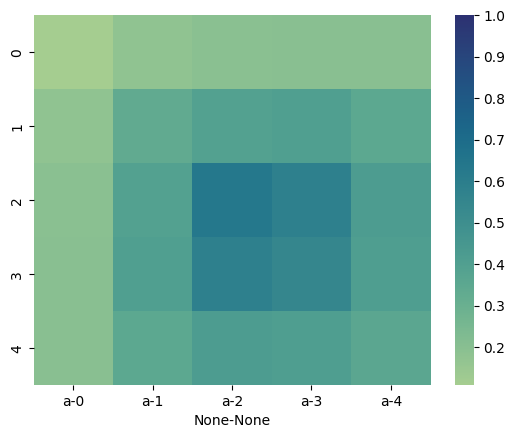

In [5]:
import matplotlib.animation as animation 
writervideo = animation.PillowWriter(fps=1) 
anim_h.save('./out/advection.gif', writer=writervideo) 